# LSTM

# Load libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy, precision
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# %matplotlib inline
# %config InlineBackend.figure_format='retine'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 16, 10

In [3]:
pl.seed_everything(4)

Global seed set to 4


4

# Load data

In [4]:
user = 'participant3'
interval = '15min'

columns = [ 'timestamp', 'heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Include FonLog data
columns = columns + ['time_from_last_drug_taken'] #, 'wo_duration']

# 'wearing_off' | 'wearing_off_post_meds' | 'wearing_off_lead60'
target_column = 'wearing_off' 
columns.append(target_column)

# With lag features
lag_features = []
for column in columns[1:]:
    lag_features.append(f'{column}-1')
columns = columns + lag_features

In [5]:
participant_dictionary = {
#     'participant1': {
#         'name': 'mori-san',
#         'fonlog_id': 5,
#         'start_date': '2021-02-23',        # start date '2021-11-25'
#         'end_date_plus_one': '2021-03-24', # actual end date '2021-11-29'
#         'end_date_plus_two': '2021-03-25'  # boundary excluding specified date '2021-11-30'
#     },
#     'participant2': {
#         'name': 'iwai-san',
#         'fonlog_id': 6,
#         'start_date': '2021-02-23',        # '2021-11-24'
#         'end_date_plus_one': '2021-03-24', # '2021-11-29'
#         'end_date_plus_two': '2021-03-25'  # '2021-11-30'
#     },
    'participant1': {
        'name': 'mori-san',
        'fonlog_id': 5,
        'start_date': '2021-11-25',        # start date '2021-11-25'
        'end_date_plus_one': '2021-12-03', # actual end date '2021-11-29'
        'end_date_plus_two': '2021-12-04'  # boundary excluding specified date '2021-11-30'
    },
    'participant2': {
        'name': 'iwai-san',
        'fonlog_id': 6,
        'start_date': '2021-11-24',        # '2021-11-24'
        'end_date_plus_one': '2021-11-29', # '2021-11-29'
        'end_date_plus_two': '2021-11-30'  # '2021-11-30'
    },
    'participant3': {
        'name': 'ushijima-san', # Shibata Lab 13
        'fonlog_id': 7,
        'start_date': '2021-11-17',
        'end_date_plus_one': '2021-11-26', # 10 days
        'end_date_plus_two': '2021-11-27'
    },
    'participant4': {
        'name': 'haneji-san', # Shibata Lab 14
        'fonlog_id': 8,
        'start_date': '2021-11-28',
        'end_date_plus_one': '2021-12-07', # 11 days
        'end_date_plus_two': '2021-12-08'
    },
    'participant5': {
        'name': 'nakazawa-san', # Shibata Lab 15
        'fonlog_id': 9,
        'start_date': '2021-11-22',
        'end_date_plus_one': '2021-11-29', # 9 days
        'end_date_plus_two': '2021-11-30'
    },
    'participant6': {
        'name': 'inoue-san', # Shibata Lab 16
        'fonlog_id': 10,
        'start_date': '2021-11-29',
        'end_date_plus_one': '2021-12-07', # 11 days
        'end_date_plus_two': '2021-12-08'
    },
    'participant7': {
        'name': 'sugimoto-san', # Shibata Lab 17
        'fonlog_id': 11,
        'start_date': '2021-12-09',
        'end_date_plus_one': '2021-12-14', # 6 days
        'end_date_plus_two': '2021-12-15'
    },
    'participant8': {
        'name': 'uozumi-sensei1', # Shibata Lab 18
        'fonlog_id': 12,
        'start_date': '2021-12-14',
        'end_date_plus_one': '2021-12-24', # 11 days
        'end_date_plus_two': '2021-12-25'
    },
    'participant9': {
        'name': 'uozumi-sensei2', # Shibata Lab 19
        'fonlog_id': 13,
        'start_date': '2021-12-14',
        'end_date_plus_one': '2021-12-24', # 11 days
        'end_date_plus_two': '2021-12-25'
    },
    'participant10': {
        'name': 'uozumi-sensei3', # Shibata Lab 20
        'fonlog_id': 14,
        'start_date': '2021-12-15',
        'end_date_plus_one': '2021-12-24', # 10 days
        'end_date_plus_two': '2021-12-25'
    }
}

In [6]:
combined_data = pd.read_excel(f'./data/4-combined_data_{user}_{interval}.xlsx',
                              index_col="timestamp",
                              usecols=columns,
                              engine='openpyxl')
combined_data.fillna(0, inplace=True)
combined_data = combined_data.loc[
    (combined_data.index >= participant_dictionary[user]['start_date']) &
    (combined_data.index < participant_dictionary[user]['end_date_plus_two'])
]
    

# y = combined_data.loc[:, combined_data.columns == target_column].values[:,0]
y = combined_data[[target_column]]
X = combined_data.loc[:, [column for column in columns[1:] if column != target_column]]

X_train = X
y_train = y

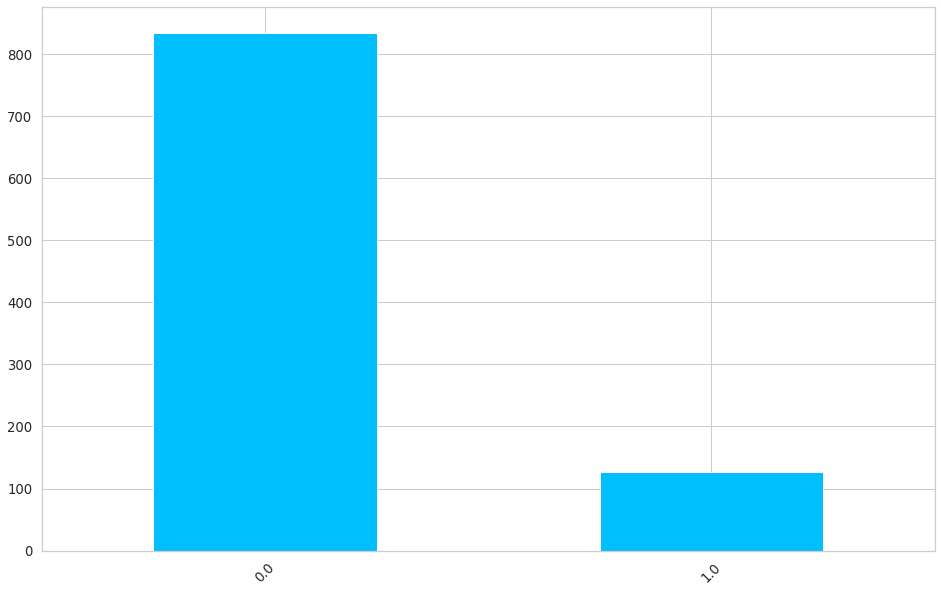

In [7]:
y.wearing_off.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

# Preprocessing

In [8]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.wearing_off)

In [9]:
y_train["label"] =  encoded_labels

/tmp/ipykernel_7410/3341449311.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train["label"] =  encoded_labels


In [10]:
y_train.head()

,wearing_off,label
timestamp,,
2021-11-17 00:00:00,0.0,0
2021-11-17 00:15:00,0.0,0
2021-11-17 00:30:00,0.0,0
2021-11-17 00:45:00,0.0,0
2021-11-17 01:00:00,0.0,0


In [11]:
FEATURE_COLUMNS = X_train.columns.tolist()
FEATURE_COLUMNS

['heart_rate',
 'steps',
 'stress_score',
 'awake',
 'deep',
 'light',
 'rem',
 'nonrem_total',
 'total',
 'nonrem_percentage',
 'sleep_efficiency',
 'time_from_last_drug_taken',
 'heart_rate-1',
 'steps-1',
 'stress_score-1',
 'awake-1',
 'deep-1',
 'light-1',
 'rem-1',
 'nonrem_total-1',
 'total-1',
 'nonrem_percentage-1',
 'sleep_efficiency-1',
 'time_from_last_drug_taken-1',
 'wearing_off-1']

In [12]:
sequences = []

for timestamp, data in X_train.groupby('timestamp'):
    sequence_features = data[FEATURE_COLUMNS].reset_index(drop=True)
    label = y_train[y_train.index == timestamp].iloc[0].label
    
    sequences.append((sequence_features, label))

In [13]:
sequences[0]

(   heart_rate  steps  stress_score  awake  deep  light    rem  nonrem_total  \
 0   47.983333    0.0           3.2    2.0   0.0  256.0  205.0         256.0   
 
    total  nonrem_percentage  ...  awake-1  deep-1  light-1  rem-1  \
 0  461.0           0.555315  ...      0.0     0.0      0.0    0.0   
 
    nonrem_total-1  total-1  nonrem_percentage-1  sleep_efficiency-1  \
 0             0.0      0.0                  0.0                 0.0   
 
    time_from_last_drug_taken-1  wearing_off-1  
 0                          0.0            0.0  
 
 [1 rows x 25 columns],
 0.0)

In [14]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)

In [15]:
len(train_sequences), len(test_sequences)

(768, 192)

# Dataset

In [16]:
class NonMotorDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label=torch.tensor(label).long()
        )

In [17]:
class NonMotorDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def setup(self, stage=None):
        self.train_dataset = NonMotorDataset(self.train_sequences)
        self.test_dataset = NonMotorDataset(self.test_sequences)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=cpu_count()
        )
    
    def validation_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )

In [18]:
N_EPOCHS = 250
BATCH_SIZE = 64

data_module = NonMotorDataModule(train_sequences, test_sequences, BATCH_SIZE)

# Model

In [19]:
from torch import nn

class WearingOffModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers= n_layers,
            batch_first=True,
            dropout=0.75
        )
        self.classifier = nn.Linear(n_hidden, n_classes)
        
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        
        out = hidden[-1]
        return self.classifier(out)

In [20]:
class WearingOffPredictor(pl.LightningModule):
    
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = WearingOffModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        # step_accuracy = accuracy(predictions, labels)
        step_accuracy = precision(predictions, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        # step_accuracy = accuracy(predictions, labels)
        step_accuracy = precision(predictions, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}
    
    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        # step_accuracy = accuracy(predictions, labels)
        step_accuracy = precision(predictions, labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)

In [21]:
model = WearingOffPredictor(
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)

In [22]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs --bind_all

In [23]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="wearing-off")

trainer = pl.Trainer(
    logger = logger,
    enable_checkpointing = checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:96: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)
# trainer.test()

/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


# Predictions

In [ ]:
trained_model = WearingOffPredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(label_encoder.classes_)
)

trained_model.freeze()

In [ ]:
test_dataset = NonMotorDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]
    
    _, output = trained_model(sequence.unsqueeze(dim=0))
    prediction = torch.argmax(output, dim=1)
    predictions.append(prediction.item())
    labels.append(label.item())

In [ ]:
print(
    classification_report(labels, predictions)
)